<a href="https://colab.research.google.com/github/Kirankavala143/Fmml-assignment/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-12 13:06:32--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.238.217.118, 18.238.217.65, 18.238.217.86, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.238.217.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   238MB/s    in 0.2s    

2024-05-12 13:06:32 (238 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


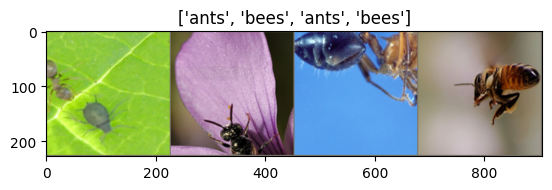

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6092 Acc: 0.6926

Epoch 1/4
----------
Loss: 0.6848 Acc: 0.7090

Epoch 2/4
----------
Loss: 0.7262 Acc: 0.6844

Epoch 3/4
----------
Loss: 0.7871 Acc: 0.7336

Epoch 4/4
----------
Loss: 0.4929 Acc: 0.8074



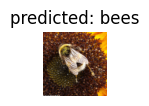

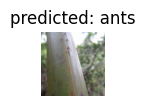

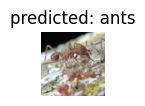

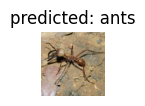

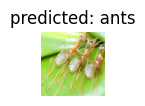

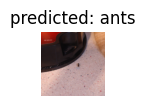

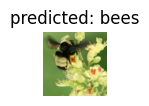

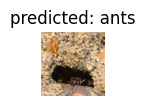

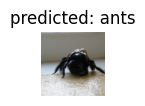

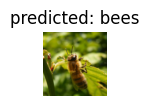

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


ANSWERS:

1ST ANSWER:

Data augmentations, such as resizing, cropping, rotating, flipping, and adjusting brightness/contrast, play a crucial role in training deep learning models, particularly in computer vision tasks. Here's why they're significant:

1.Increased Dataset Size: Augmentations effectively increase the size of your training dataset by generating new, slightly modified samples from existing ones. This helps prevent overfitting and allows the model to learn more robust features.

2.Regularization: Augmentations act as a form of regularization by adding noise to the training data. This helps prevent the model from memorizing specific patterns in the training data and encourages it to learn more generalizable features.

3.Improved Generalization: By exposing the model to a wider variety of data variations during training, augmentations help the model generalize better to unseen data. This is especially important when the test data may contain variations not present in the training set.

4.Robustness to Variations: Augmentations help the model become more robust to variations in input data, such as changes in scale, orientation, lighting conditions, and occlusions. This makes the model more reliable when deployed in real-world scenarios where such variations are common.

5.Invariance Learning: Some augmentations, like random rotations and flips, help the model learn invariance to certain transformations. For example, if your task involves classifying objects in images, augmentations like rotation and flipping can help the model learn that the orientation of objects doesn't affect their identity.

6.Domain Adaptation: Augmentations can also be used for domain adaptation, where the distribution of the training data differs from that of the test data. By simulating variations present in the target domain during training, augmentations help the model adapt better to the target domain.

Overall, augmentations are a powerful tool for improving the performance and generalization of deep learning models, especially in tasks like image classification, object detection, and segmentation.

2ND ANSWER:

If you train a ResNet model from scratch without using pre-trained weights, the performance might be significantly affected. Training a deep neural network like ResNet from scratch requires a large amount of labeled data and computational resources. Without pre-trained weights, the model has to learn meaningful representations of the data entirely from scratch, which can be challenging and may lead to suboptimal results, especially if the dataset is small or if the model architecture is very deep.

Here are some potential outcomes if you train ResNet from scratch without using pre-trained weights:

1.Lower Accuracy: The model may achieve lower accuracy compared to using pre-trained weights, especially if the dataset is not large enough to learn meaningful representations.

2.Slower Convergence: Training from scratch may require more epochs to converge compared to using pre-trained weights, as the model needs to learn all features from scratch.

3.Higher Risk of Overfitting: Without the regularization effect of pre-trained weights, there's a higher risk of overfitting to the training data, especially if the model architecture is complex and the dataset is small.

4.Increased Training Time: Training from scratch typically requires more computational resources and time compared to fine-tuning a pre-trained model, as the model has to learn all parameters from scratch.

5.Dependency on Initialization: The performance of the model may depend more on the initialization scheme and hyperparameters chosen for training, as there are no pre-trained weights to provide a good starting point.

Overall, while training ResNet from scratch is possible, it may not yield optimal performance unless you have a large dataset and sufficient computational resources for training. Using pre-trained weights as a starting point for fine-tuning is often a more effective approach, especially for tasks with limited data or computational resources.

3RD ANSWER:
The performance of a pre-trained ResNet model on a new dataset, such as the ants vs. bees dataset, depends on several factors:

1.Domain Similarity: If the dataset the ResNet model was pre-trained on is significantly different from the ants vs. bees dataset in terms of domain, content, or characteristics (e.g., different types of objects, scenes, lighting conditions), the performance may not be as good. Pre-trained models tend to transfer better to tasks and datasets that are similar to the original training data.

2.Task Similarity: The performance may also depend on the similarity of the tasks between the pre-training dataset and the target dataset. For example, if the pre-training dataset involved classifying natural images, and the target dataset (ants vs. bees) also involves classifying natural images, the transfer may be more effective compared to a completely unrelated task.

3.Feature Relevance: Even if the pre-trained model was trained on a different dataset, the lower layers of the network might have learned general features (e.g., edges, textures) that are relevant across different datasets and tasks. In such cases, fine-tuning the pre-trained model may still lead to good performance, especially if the differences between the datasets are not too significant.

4.Amount of Transfer Learning: The effectiveness of transfer learning depends on how much the pre-trained model's features can be adapted to the new dataset. Fine-tuning involves updating the model's parameters to better suit the target dataset, and the degree of fine-tuning required may vary depending on the similarity between the datasets.

In summary, while using a pre-trained ResNet model on the ants vs. bees dataset may still provide a good starting point for training, the performance ultimately depends on the similarity between the pre-training dataset and the target dataset, as well as the effectiveness of transfer learning in adapting the pre-trained features to the new task. Fine-tuning and possibly additional training on the target dataset are often necessary to achieve the best performance.